# Clasificación de Imágenes Dermatológicas con EfficientNetB0

## 1. IMPORTACIÓN DE LIBRERÍAS
Importamos las librerías necesarias para el procesamiento de datos, construcción y entrenamiento del modelo.

In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


## 2. Configuración de parámetros y recursos
Configuramos los parámetros principales y verificamos la disponibilidad de GPU para acelerar el entrenamiento.

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18124444362209070600
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3693584384
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8828460759790903735
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:26:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [4]:
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
mixed_precision.set_global_policy('mixed_float16')

# Parámetros
img_size = (224, 224)
batch_size = 32
epochs = 100
seed = 123
train_dir = '../dataset/multi-6/train'
test_dir = '../dataset/multi-6/test'
model_path = 'efficientnetb0_derma_v4.keras'

## 3. Carga y preparación de datos
Cargamos las imágenes desde las carpetas, dividimos en entrenamiento y validación, y mostramos información básica.

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)
# Obtener número de clases
class_names = train_ds.class_names
num_classes = len(class_names)
print("Clases:", class_names)

#Imprimir dataset
for x, y in train_ds.take(5):
    print("Imagen shape:", x.shape)
    print("Etiqueta:", y.numpy())


Found 30901 files belonging to 6 classes.
Using 24721 files for training.
Found 30901 files belonging to 6 classes.
Using 6180 files for validation.
Clases: ['Acne', 'Benign', 'Eczema', 'Infectious', 'Malign', 'Pigmentation']
Imagen shape: (32, 224, 224, 3)
Etiqueta: [0 1 3 1 1 3 0 4 2 2 1 3 1 1 5 1 3 4 1 1 1 3 1 1 1 1 2 1 2 3 1 0]
Imagen shape: (32, 224, 224, 3)
Etiqueta: [0 1 5 1 1 1 4 3 1 0 3 1 4 1 3 4 4 1 2 1 5 4 4 4 3 1 2 0 4 1 1 4]
Imagen shape: (32, 224, 224, 3)
Etiqueta: [1 0 0 4 1 3 1 4 1 3 3 4 5 4 3 4 2 4 1 4 3 4 4 1 4 4 1 3 3 3 1 1]
Imagen shape: (32, 224, 224, 3)
Etiqueta: [1 3 1 1 1 1 1 1 4 0 3 4 1 2 3 1 1 5 2 1 4 2 3 3 4 4 2 2 1 1 1 2]
Imagen shape: (32, 224, 224, 3)
Etiqueta: [2 4 1 1 2 3 3 3 4 3 1 0 1 1 3 5 3 5 2 4 2 1 3 1 1 0 0 4 3 4 1 0]


## 4. Ajuste de pesos por clase y penalización por peligrosidad
Para mejorar la sensibilidad del modelo ante clases peligrosas, ajustamos los pesos de las clases según su peligrosidad.

In [28]:
# ---------------------------------------
# CÁLCULO DE PESOS POR CLASE
# ---------------------------------------

# Contar imágenes por clase
image_counts = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    count = len(os.listdir(class_path))
    image_counts.append(count)

# Crear vector de etiquetas reales
y_train = []
for i, count in enumerate(image_counts):
    y_train += [i] * count
y_train = np.array(y_train)

# Calcular pesos automáticos por desbalance
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(weights))

# ---------------------------------------
# PENALIZACIÓN ADICIONAL POR PELIGROSIDAD
# ---------------------------------------
# Define los niveles de peligrosidad
high_danger = {4}              # Malign
moderate_danger = {2, 3}       # Eczema, Infectious
low_danger = set(range(len(class_names))) - high_danger - moderate_danger

# Define multiplicadores
danger_multipliers = {}
for c in range(len(class_names)):
    if c in high_danger:
        danger_multipliers[c] = 5.0
    elif c in moderate_danger:
        danger_multipliers[c] = 3.0
    else:
        danger_multipliers[c] = 1.0

# Ajuste final combinando ambos criterios
adjusted_class_weight = {}
for cls in class_weight:
    adjusted_class_weight[cls] = class_weight[cls] * danger_multipliers[cls]

malign_class = 4  # índice de la clase Malign
max_other_weight = max(w for c, w in adjusted_class_weight.items() if c != malign_class)

if adjusted_class_weight[malign_class] <= max_other_weight:
    adjusted_class_weight[malign_class] = max_other_weight + 0.1  # o +1 si quieres una diferencia más clara

print("Pesos por clase ajustados:", adjusted_class_weight)


Pesos por clase ajustados: {0: 2.396618582286335, 1: 0.4733762254901961, 2: 3.7963144963144964, 3: 2.5751666666666666, 4: 5.149346405228758, 5: 5.049346405228758}


## 5. Optimización del pipeline de datos
Utilizamos técnicas de cacheo y prefetch para acelerar el entrenamiento y la validación.

In [29]:
# Optimización de rendimiento
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Configuración de caché y prefetch
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


## 6. Construcción y compilación del modelo
Definimos la arquitectura del modelo utilizando EfficientNetB0 como base y añadimos capas densas para la clasificación.

In [30]:
# Modelo base (preentrenado)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # congelamos capas base

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.GaussianNoise(0.2)
])


# Modelo completo (sin preprocessing dentro)
model = models.Sequential([
    base_model,
    data_augmentation,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compilar modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## 7. Entrenamiento del modelo
Entrenamos el modelo utilizando los datos preparados y los pesos ajustados, con callbacks para evitar sobreajuste.

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(model_path, save_best_only=True)
]

# Entrenamiento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=adjusted_class_weight 
)

Epoch 1/100
773/773 ━━━━━━━━━━━━━━━━━━━━ 2366s 3s/step - accuracy: 0.5836 - loss: 1.0484 - val_accuracy: 0.6850 - val_loss: 0.7711
Epoch 2/100
773/773 ━━━━━━━━━━━━━━━━━━━━ 2322s 3s/step - accuracy: 0.6919 - loss: 0.7600 - val_accuracy: 0.7262 - val_loss: 0.6845
Epoch 3/100
773/773 ━━━━━━━━━━━━━━━━━━━━ 2321s 3s/step - accuracy: 0.7339 - loss: 0.6684 - val_accuracy: 0.7537 - val_loss: 0.6412
Epoch 4/100
773/773 ━━━━━━━━━━━━━━━━━━━━ 2325s 3s/step - accuracy: 0.7534 - loss: 0.5994 - val_accuracy: 0.7660 - val_loss: 0.6096
Epoch 5/100
773/773 ━━━━━━━━━━━━━━━━━━━━ 2321s 3s/step - accuracy: 0.7754 - loss: 0.5382 - val_accuracy: 0.7793 - val_loss: 0.5910
Epoch 6/100
773/773 ━━━━━━━━━━━━━━━━━━━━ 2282s 3s/step - accuracy: 0.7853 - loss: 0.5047 - val_accuracy: 0.7825 - val_loss: 0.5763
Epoch 7/100
773/773 ━━━━━━━━━━━━━━━━━━━━ 2284s 3s/step - accuracy: 0.8020 - loss: 0.4684 - val_accuracy: 0.7924 - val_loss: 0.5700
Epoch 8/100
773/773 ━━━━━━━━━━━━━━━━━━━━ 2300s 3s/step - accuracy: 0.8184 - loss: 0

### Visualización del entrenamiento

A continuación, se muestran las curvas de pérdida y precisión

NameError: name 'history' is not defined

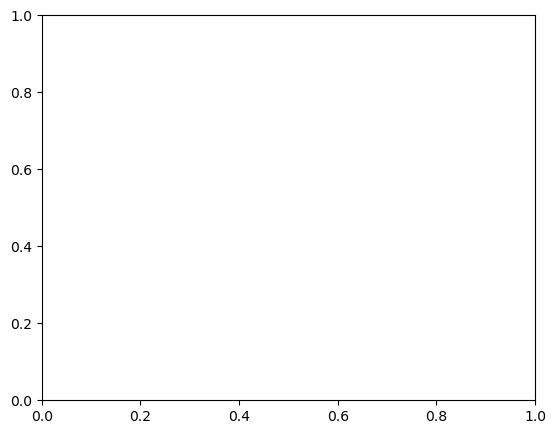

In [31]:
plt.figure(figsize=(14,5))

# Precisión
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

### Distribución de imágenes por clase en el set de entrenamiento

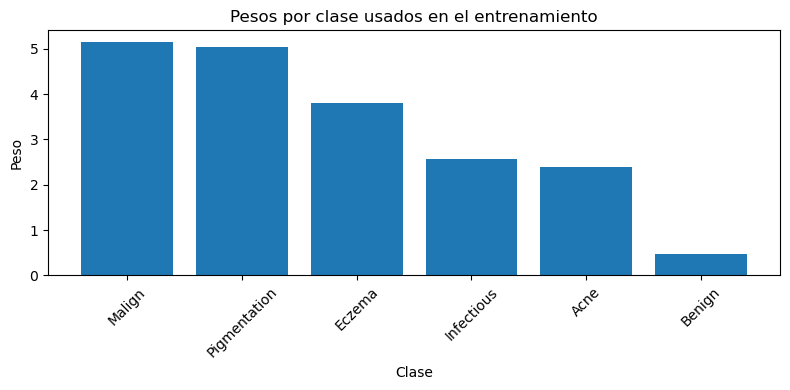

In [32]:
pesos_df = pd.DataFrame({
    'Clase': [class_names[c] for c in adjusted_class_weight.keys()],
    'Peso': [adjusted_class_weight[c] for c in adjusted_class_weight.keys()]
})
pesos_df = pesos_df.sort_values('Peso', ascending=False)

plt.figure(figsize=(8,4))
plt.bar(pesos_df['Clase'], pesos_df['Peso'])
plt.title('Pesos por clase usados en el entrenamiento')
plt.ylabel('Peso')
plt.xlabel('Clase')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

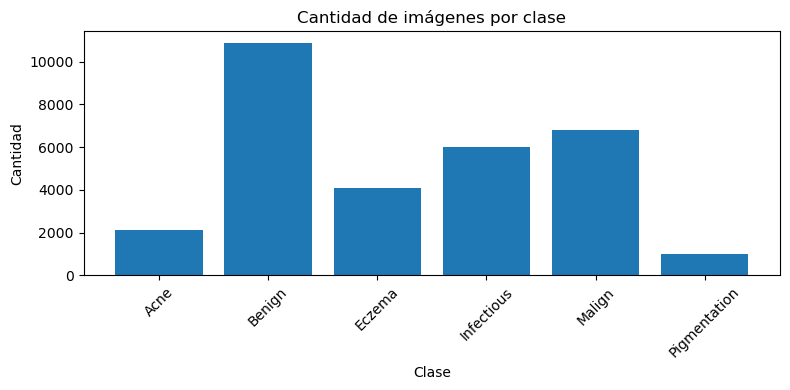

In [33]:
plt.figure(figsize=(8,4))
plt.bar(class_names, image_counts)
plt.title('Cantidad de imágenes por clase')
plt.ylabel('Cantidad')
plt.xlabel('Clase')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Ejemplos de imágenes aumentadas

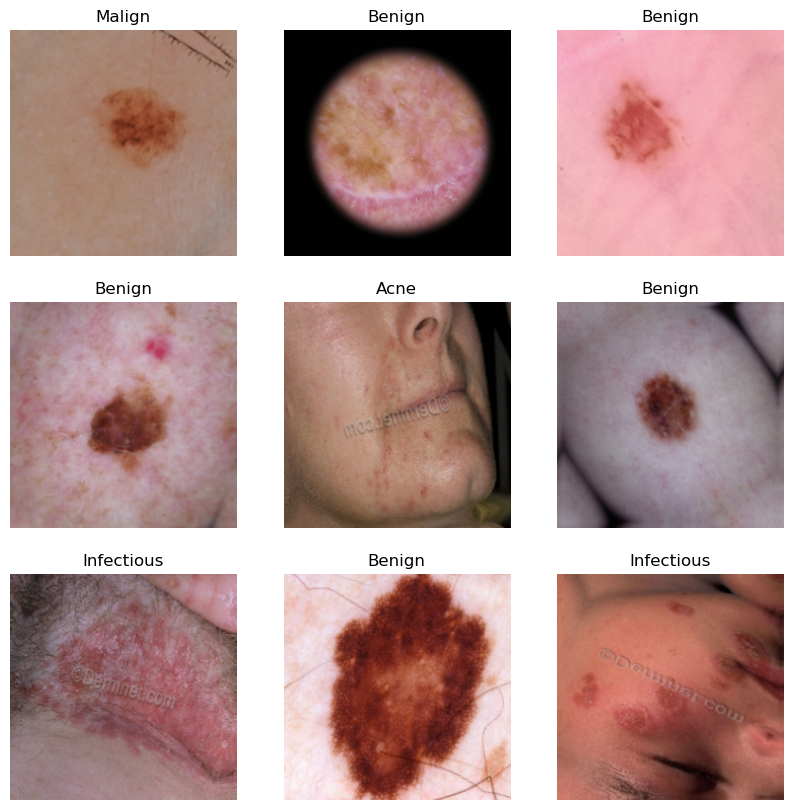

In [34]:
for images, labels in train_ds.take(1):
    augmented_images = data_augmentation(images)
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

## 8. Evaluación y visualización de resultados
Evaluamos el modelo en el conjunto de test, mostramos el reporte de clasificación y la matriz de confusión.

In [40]:
# Cargar modelo entrenado
model = tf.keras.models.load_model(model_path)

# Cargar dataset de test
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False  # MUY IMPORTANTE para alinear predicciones con etiquetas
)

# Obtener nombres de clase
class_names = test_ds.class_names
num_classes = len(class_names)

# Prefetch para acelerar
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Obtener predicciones
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener etiquetas reales
y_true = np.concatenate([y.numpy() for x, y in test_ds])

# Reporte de clasificación
print("🧾 Clasification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


ValueError: File not found: filepath=efficientnetb0_v2.keras. Please ensure the file is an accessible `.keras` zip file.